### How to process your Cy3 expression footprint images?

#### This script recreates figures FigS3 in SM-Omics: An automated platform for high-throughput spatial multi-omics; doi: https://doi.org/10.1101/2020.10.14.338418 

Expected run time: 1-2 mins \
Expected results: Cy3 signals histogram detected under tissue boundaries

Load libraries

In [2]:
import matplotlib.pyplot as plt
import matplotlib
import skimage
import os
from skimage import io
from skimage.color import rgb2gray
import scipy.ndimage as ndi
from scipy.ndimage import gaussian_filter
import numpy as np
from skimage import img_as_float
from skimage.morphology import reconstruction, watershed, closing, square, remove_small_objects
from skimage.filters import sobel
from skimage.morphology import watershed
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.util import invert
import pandas as pd

# set axis 
matplotlib.rcParams['font.size'] = 12

Read in example image file

In [31]:
# raw data files needed to run are available at SCP: https://singlecell.broadinstitute.org/single_cell/study/SCP979/
# please download part0_replication.zip

In [32]:
filename = os.path.join('./data/part0_replication/', 'Pos1_Cy3.C1.jpg')
dtnm = "Pos1_Cy3.C1.jpg_signals.csv" # name 
pltnm = "Pos1_Cy3.C1.jpg_signals.png" #output file name

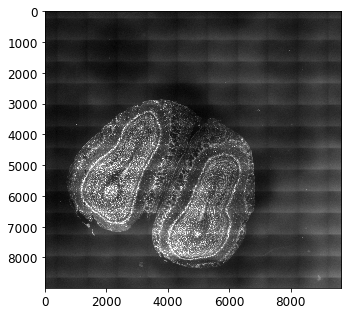

In [33]:
# read in
moon = io.imread(filename, plugin='matplotlib')
image = rgb2gray(moon)
image_smooth = ndi.gaussian_filter(image, .01)

#plot 2d image as precaution to check image
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(image_smooth, interpolation='nearest', cmap = 'gray')
plt.tight_layout()

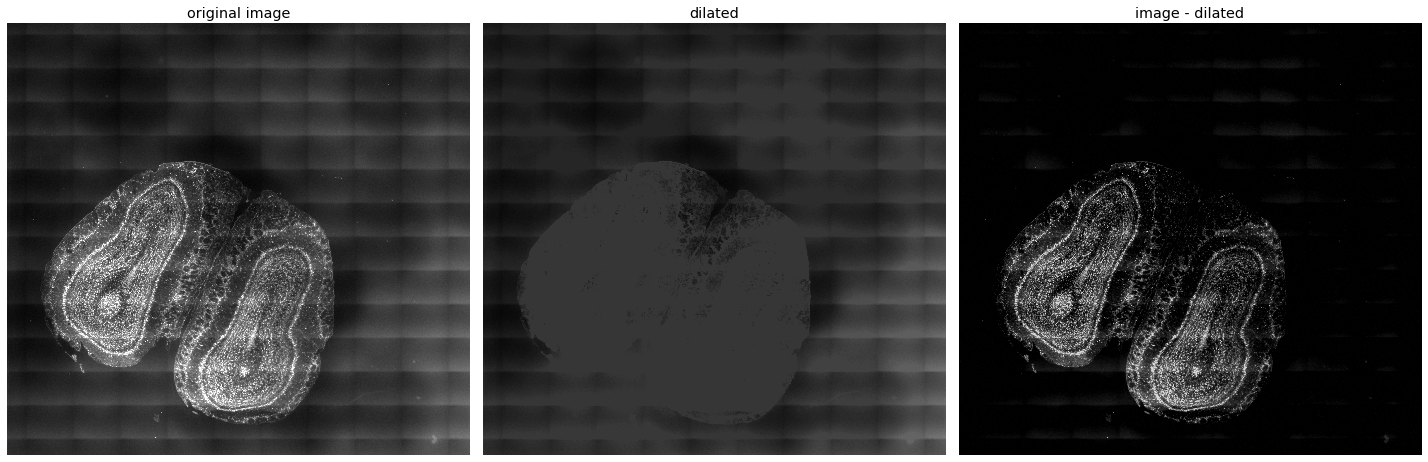

In [34]:
# Dilate image (note: this might take a while)
image = image_smooth

seed = np.copy(image_smooth)
seed[1:-1, 1:-1] = image.min()
mask = image

dilated = reconstruction(seed, mask, method='dilation')

#plot
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1,
                                    ncols=3,
                                    figsize=(20, 20),
                                    sharex=True,
                                    sharey=True)

ax0.imshow(image, cmap='gray')
ax0.set_title('original image')
ax0.axis('off')

ax1.imshow(dilated, vmin=image.min(), vmax=image.max(), cmap='gray')
ax1.set_title('dilated')
ax1.axis('off')

ax2.imshow(image - dilated, cmap='gray')
ax2.set_title('image - dilated')
ax2.axis('off')

fig.tight_layout()

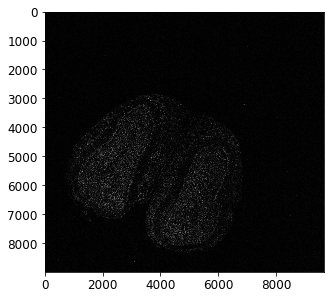

In [35]:
# Make sobel elevation
elevation_map = sobel(image)

# plot
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(elevation_map, cmap=plt.cm.gray, interpolation='nearest')

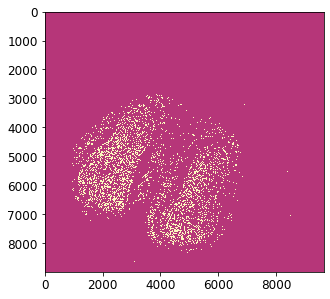

In [37]:
# binarize image
markers = np.zeros_like(elevation_map)
markers[elevation_map < 0.05] = 1
markers[elevation_map > 0.05] = 2

#plot
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(markers, cmap='magma', interpolation='nearest')

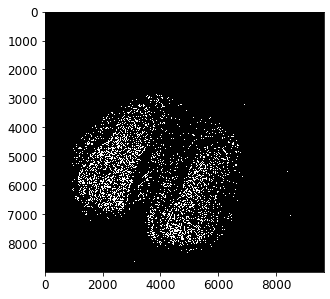

In [38]:
# segment into a "tissue like" object
segmentation = watershed(elevation_map, markers, connectivity=20000)

#plot
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(segmentation, cmap=plt.cm.gray, interpolation='nearest')


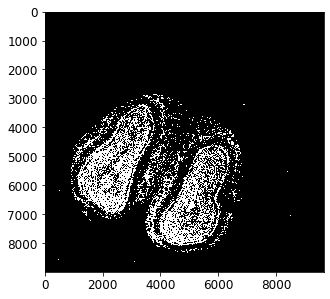

In [39]:
# apply threshold
bw = closing(segmentation > 1, square(10))

# remove artifacts connected to image border
cleared = clear_border(bw)

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(cleared, cmap='gray')

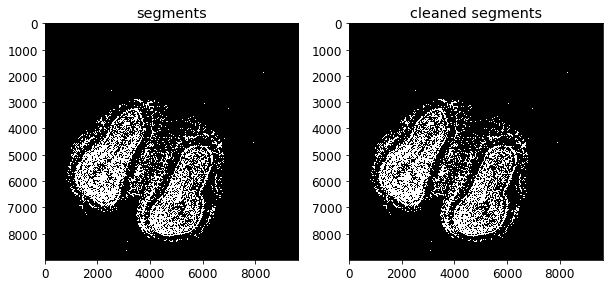

In [40]:
# remove leftover small object
cleaned = remove_small_objects(cleared, min_size=5)

#plot
fig, axs = plt.subplots(1, 2, figsize = (10,5))
axs[0].imshow(cleared, cmap='gray')
axs[0].set_title('segments')
axs[1].imshow(cleaned, cmap='gray')
axs[1].set_title('cleaned segments')
plt.show(fig)

(-0.5, 9641.5, 8991.5, -0.5)

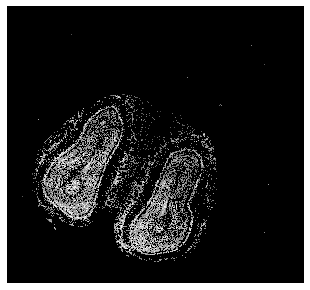

In [41]:
# invert tissue signal in order to substract background
segmentation_invert = cleaned

# get image without background
s=np.where(segmentation_invert==False, False, image_smooth)

#plot 2d rgb image
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(s, interpolation='nearest', cmap = 'gray')
plt.tight_layout()
plt.axis('off')

# save output figure
# plt.savefig(pltnm, transparent = True, bbox_inches = 'tight', pad_inches = 0)

(array([1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 5.00000e+00,
        0.00000e+00, 2.10000e+01, 0.00000e+00, 1.50000e+01, 0.00000e+00,
        1.90000e+01, 0.00000e+00, 1.90000e+01, 0.00000e+00, 3.10000e+01,
        0.00000e+00, 4.30000e+01, 0.00000e+00, 4.60000e+01, 0.00000e+00,
        6.30000e+01, 0.00000e+00, 8.70000e+01, 0.00000e+00, 1.13000e+02,
        0.00000e+00, 1.28000e+02, 0.00000e+00, 1.80000e+02, 0.00000e+00,
        2.45000e+02, 0.00000e+00, 2.71000e+02, 0.00000e+00, 3.08000e+02,
        0.00000e+00, 3.88000e+02, 0.00000e+00, 4.71000e+02, 0.00000e+00,
        5.29000e+02, 0.00000e+00, 6.17000e+02, 0.00000e+00, 6.98000e+02,
        0.00000e+00, 8.99000e+02, 0.00000e+00, 1.02300e+03, 0.00000e+00,
        1.22700e+03, 0.00000e+00, 1.35000e+03, 0.00000e+00, 1.57600e+03,
        0.00000e+00, 1.82700e+03, 0.00000e+00, 2.10900e+03, 0.00000e+00,
        2.40600e+03, 0.00000e+00, 2.84400e+03, 0.00000e+00, 3.24400e+03,
        0.00000e+00, 3.66500e+03, 0.00000e+00, 4.16

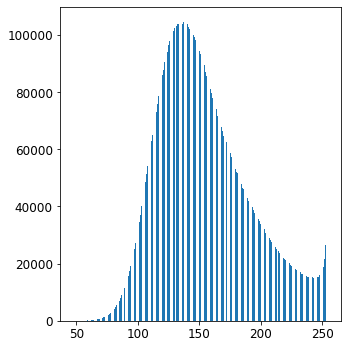

In [43]:
# make np array or signals that aren't 0 in the image
s1=s.flatten()
s2=s1[s1!=0]

#plot signals histogram
fig, axs = plt.subplots(sharey=True, tight_layout=True, figsize= (5,5))

# We can set the number of bins with the `bins` kwarg
axs.hist(s2, bins='auto')

# save output numpy array 
# pd.DataFrame(s2).to_csv(dtnm, index = False)